#### Load needed modules
Here we load the needed python modules for using this notebook

In [62]:
# Import the needed Modules
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
import numpy as np
import datetime
import pathlib

#### Make presettings for plotting
We makue use of the matplotlib rcParams, with which we can define the default settings for plotting. Here we define the default extension for exporting the plots. If this is changed all plots, if not otherwise specified, use this extension. 

In [2]:
# Set Default values for plotting
default_picture_extension = 'png'
mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['savefig.format'] = default_picture_extension

##### Backup of Data
Th function saves the given data as local backup using the current timestamp as name.

In [63]:
# makes a backup of the data given either as csv or excel file
def make_backup(data, format='excel'):
    '''
    Saves the given dataframe as a backup in the backups folder.
    The backup will be saved as excel or csv file.
    The name of the backup will be 'backup_YYYY-MM-DD_HHMMSS.xlsx/csv'
    :param data: The dataframe to be saved as backup
    :param format: The format of the backup. Either 'excel' or 'csv'
    '''

    # Get the current timestamp in the Format YYYY-MM-DD_HHMMSS
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")

    # Create the backups folder if it does not exist
    pathlib.Path('backups').mkdir(parents=True, exist_ok=True)
    
    # Save the analysis_df as excel file
    if format == 'excel':
        data.to_excel(f'backups/backup_{timestamp}.xlsx', index=False)
    
    # Save the analysis_df as excel file
    elif format == 'csv':       
        data.to_csv(f'backups/backup_{timestamp}.csv', index=False)

#### 1. Load the Data from the Google Spreadsheet

We directly obtain the data from the Google Spreadsheet. Therefore we make use of the URLand the pandas.read_csv() function is used. Hereby the worksheet is identified by an ID (gid), which can be seen in the URL when accessing the google document.



In [65]:
# Import Data from the spreadsheet
url_analysis = f'https://docs.google.com/spreadsheets/d/1xRNNF-eCuBvnxLSZP7ymnockQQJBWdoaCqzOfWYWLx8/export?gid=0&format=csv'
url_reference = f'https://docs.google.com/spreadsheets/d/1xRNNF-eCuBvnxLSZP7ymnockQQJBWdoaCqzOfWYWLx8/export?gid=1903780682&format=csv'
url_scenarios = f'https://docs.google.com/spreadsheets/d/1xRNNF-eCuBvnxLSZP7ymnockQQJBWdoaCqzOfWYWLx8/export?gid=300138599&format=csv'
url_sectors = 'https://docs.google.com/spreadsheets/d/1xRNNF-eCuBvnxLSZP7ymnockQQJBWdoaCqzOfWYWLx8/export?gid=2053313174&format=csv'
url_additional_parameters = 'https://docs.google.com/spreadsheets/d/1xRNNF-eCuBvnxLSZP7ymnockQQJBWdoaCqzOfWYWLx8/export?gid=855869427&format=csv'

# Load data from Sheet Scenario Analysis
analysis_df = pd.read_csv(url_analysis, usecols=np.arange(0,16))
analysis_df['Value'] = pd.to_numeric(analysis_df['Value'], errors='coerce')
analysis_df['Year'] = pd.to_numeric(analysis_df['Year'], errors='coerce')
analysis_df['Source'] = analysis_df['Source'].str.strip()
analysis_df['Scenario (name/historic/DLS)'] = analysis_df['Scenario (name/historic/DLS)'].str.strip()

# Make a backup of the analysis_df
make_backup(analysis_df, 'excel')

# Labelling and sorting of Scenarios
scenarios_df = pd.read_csv(url_scenarios)
scenarios_df['scenarios'] = scenarios_df['scenarios'].str.strip()
scenarios_df['scope'] = scenarios_df['scope'].str.strip()
scenarios_df['Source'] = scenarios_df['Source'].str.strip()

# Load data from Sheet Reference Values. Needed for Scenario names
reference_values_df = pd.read_csv(url_reference, header=[2])
reference_values_df = reference_values_df.iloc[3:22]
reference_values_df.columns.values[1:3] = ['Scenario', 'Country']

# Load data on Sectors (Which indicator is in which sector)
sectors_df = pd.read_csv(url_sectors, header=[1]).iloc[0:12]

# Load the data for additional_parameters
additional_params_df = pd.read_csv(url_additional_parameters, usecols=np.arange(0,14)).dropna(how='all')

# Bring the additional_parameter and the scenario_analysis together
analysis_df = pd.concat([analysis_df,additional_params_df], ignore_index=True)

#### 2. Preprocessing

#### 2.1 Define Mappings

We define colors for different use cases, e.g. for the sectors. Furthermore we have a Dictionary for the order of the sectors. We use thes Dictionaries for mapping.

Define Dicts for mapping

In [32]:
# Define Color schemes
sector_colours = {
    'Energy': '#a62639',
    'Industry': '#73686a',
    'Buildings': '#28249e', 
    'Mobility': '#b5711d',
    'Freight': '#6e4615',
    'Food': '#216e15'
}

study_colors = {
    'scenario 2045/50': '#132794',
    'historic': '#8496fa',
    'other regions/approaches': 'grey',
    'other regions/approaches historic': '#d4d4d4'

}

# Define Order
sector_order = {
    'Energy': 0,
    'Industry': 1,
    'Buildings': 4, 
    'Mobility': 3,
    'Freight': 2,
    'Food': 5
}

# Define Colors per Scope
scope_colors = {
    'EU27': '#0828fc',
    'EU28': '#c2113b',
    'EU28+CH': '#0d9e27',
    'single': '#703d09'
}

# Mapping for scope (as they're different in the standard_scenarios and ScenarioAnalysis sheet)
map_scope = {
    'DE': 'Germany',
    'FR': 'France',
    'UK': 'United Kingdom',
    'WD': 'global',
    'IE': 'Irland'
}

# Reversed dictionary of the map_scope dictionarys
map_scope_reverse = dict(zip(map_scope.values(),map_scope.keys()))

# Define main comparison parameters that could include international
international_parameters = [
    'average distance travelled per capita and year',
    'average distance travelled per capita and year | plane',
    'transported goods per capita and year',
]

#### 2.1 Define functions for processing data

First we define functions which are used for processing the data. The function hereby are __get_standard_scenarios__, __get_historic_data__ and __get_main_indicators__.

In [33]:
def get_standard_scenarios(raw_data, scenario_data):
    '''
    Function to get the standard scenarios from the raw data (Scenarios defined in the scenarios_final sheet)
    :param raw_data: Data from the Scenario Analysis sheet
    :param scenario_data: Data from the scenarios_final sheet
    :return: Dataframe with only the standard scenarios
    '''
    # Filter for the Coding == 1
    analysis_standard_df = raw_data[raw_data['Coding'] == 1].copy()

    # Remove Whitespaces and - out of the Geographic Scope column to have an consistent writing
    analysis_standard_df['Geographic scope'] = analysis_standard_df['Geographic scope'].str.replace(' ', '').str.replace('-', '')
    
    # Filter for standard scenarios
    standard_scenarios = scenario_data[scenario_data['standard'] == 1]

    # Get the indices of all data that belongs to the standard scenarios. Filter after Source, Scope and Scenario
    standard_scenarios_indices = standard_scenarios.apply(lambda x: analysis_standard_df[(analysis_standard_df['Source'] == x['Source']) 
                                                                                               & (analysis_standard_df['Geographic scope'] == x['scope']) 
                                                                                               & (analysis_standard_df['Scenario (name/historic/DLS)'] == x['scenarios'])].index.values, axis=1).explode().dropna()
    # Use the indices to select the correct rows from the data
    analysis_standard_df = analysis_standard_df.loc[standard_scenarios_indices]

    # Filter out kcal data
    analysis_standard_df = analysis_standard_df[~analysis_standard_df['Unit'].str.contains('kcal')].copy()
    return analysis_standard_df

In [34]:
def get_historic_data(raw_data, indicator=False):
    '''
    Function to get the historic data from the raw data.
    :param raw_data: Data from the Scenario Analysis sheet
    :param indicator: Indicator to filter after
    :return: Dataframe with only the historic data
    '''
    # Filter for the Coding == 1
    historic_indicator_data = raw_data[raw_data['Coding'] == 1].copy()

    # Remove Whitespaces and - out of the Geographic Scope column to have an consistent writing
    historic_indicator_data['Geographic scope'] = historic_indicator_data['Geographic scope'].str.replace(' ', '').str.replace('-', '')
    
    # Cheange type of year to numeric
    historic_indicator_data['Year'] = pd.to_numeric(historic_indicator_data['Year'], errors='coerce')

    # Filter for historic scenario
    historic_indicator_data = historic_indicator_data[(historic_indicator_data['Scenario (name/historic/DLS)'] == 'historic') | (historic_indicator_data['Year'] < 2045)]

    # Remove kcal data
    historic_indicator_data = historic_indicator_data[~historic_indicator_data['Unit'].str.contains('kcal')]

    # If an main indicator is given, filter also after that
    if indicator:
        historic_indicator_data = historic_indicator_data[historic_indicator_data['Main comparison parameter'] == indicator]
    return historic_indicator_data

In [35]:
def get_main_indicators(data):
    '''
    Function to get the main indicators from the data.
    :param data: Data from the Scenario Analysis sheet
    :return: List of the main indicators
    '''
    # Get the main indicators out of the data
    main_indicators = data['Main comparison parameter'].dropna().unique()
    return main_indicators

In [36]:
# Make the Anzahl Reference Values Table
historic_data = get_historic_data(analysis_df)
historic_data['Anzahl'] = 1
historic_data = historic_data.groupby(['Main comparison parameter', 'Geographic scope']).sum().reset_index()
historic_data['Indicator'] = historic_data['Main comparison parameter']
historic_data['Scope'] = historic_data['Geographic scope']
historic_data = historic_data[['Indicator', 'Scope', 'Anzahl']]
historic_data = historic_data.set_index(['Indicator', 'Scope'])
historic_data = historic_data.unstack()
historic_data.to_excel('output/Anzahl_Reference.xlsx')


### 3. Analysis
In the following we analyse the data and make different plots. Hereby for each plot we define a function, so we can reuse the process for applying it to germany.

#### 3.1 Europe/World
At first we set our scope to Europe/World, which also includes studies only having one country as a scope. Hereby we make barplots, boxplots and a scatter diagram.

##### 3.1.1 Barplot Occurences
We count for each main indicator how many times there is a study for it.

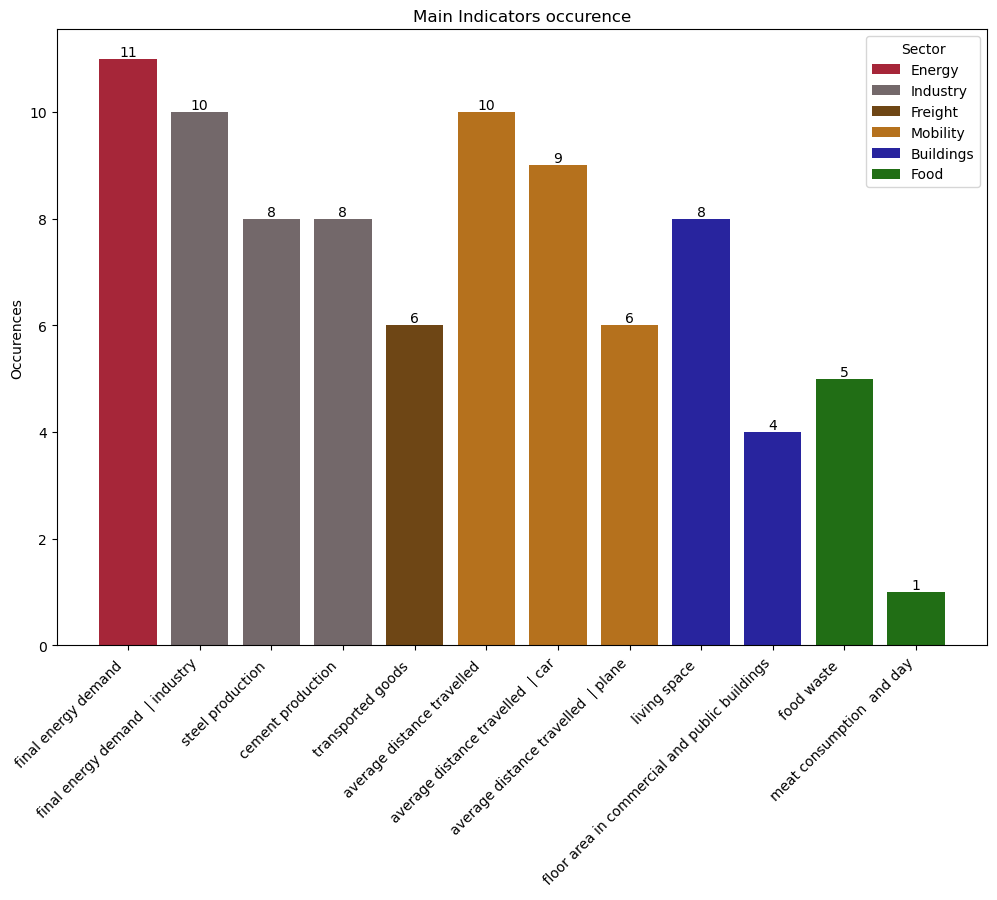

In [37]:
# Define it as a function to make it reusable
def make_barplot_occurences(data, filename, extension=False, standard=False):
    '''
    Function to make a barplot of the occurences of the main indicators.
    :param data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extension: Extension of file to be exported
    :param standard: Boolean if the data is already filtered after standard scenarios or if it has to be done
    :return: None
    '''
    # Check for the boolean standard, which indicates if the given data is already filtered after standard scenarios or if it has to be done
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data

    # Get the main indicators
    main_indicators = get_main_indicators(analysis_standard_df)

    # Get counts per Main Indicator
    main_indicator_count = analysis_standard_df['Main comparison parameter'].value_counts()

    # Create Dataframe for plotting
    main_indicators_plotting_df = pd.DataFrame(columns=['Indicator', 'Occurences', 'Sector', 'Color'])
    main_indicators_plotting_df['Indicator'] = main_indicators
    main_indicators_plotting_df['Occurences'] = main_indicators_plotting_df['Indicator']\
                                                    .apply(lambda x: main_indicator_count.loc[x])
    main_indicators_plotting_df['Sector'] =  main_indicators_plotting_df['Indicator']\
                                                    .apply(lambda x: sectors_df[sectors_df['Parameter']==x]['Sector']\
                                                    .values[0])
    main_indicators_plotting_df['Color'] = main_indicators_plotting_df['Sector']\
                                                    .apply(lambda x: sector_colours[x])
    main_indicators_plotting_df['Order'] =  main_indicators_plotting_df['Sector'].apply(lambda x: sector_order[x])

    # Sort the Values by the Order and the Occurences
    main_indicators_plotting_df = main_indicators_plotting_df\
                                    .sort_values(by=['Order', 'Occurences'], ascending=[True, False])

    # Make a bar plot
    fig, ax = plt.subplots(1)
    bar = ax.bar(main_indicators_plotting_df['Indicator'].values, 
                main_indicators_plotting_df['Occurences'].values, 
                label=main_indicators_plotting_df['Sector'].values, 
                color=main_indicators_plotting_df['Color'].values)
    ax.set_title('Main Indicators occurence')
    ax.set_ylabel('Occurences')
    ax.bar_label(bar)
    
    # Remove the per capita out of the naming to save space
    main_indicators_x_axis_naming = [s.replace('per capita and year', '')\
                                     .replace('per capita', '') for s in main_indicators_plotting_df['Indicator'].values] 
    ax.set_xticks(np.arange(len(main_indicators_plotting_df['Indicator'].values)), 
                labels=main_indicators_x_axis_naming, 
                rotation=45, 
                ha="right")
    
    # Get the correct legend without duplicate keys
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title='Sector', loc='upper right')

    # Save figure either with default extension or with extension given in the function
    if extension:
        filename = f'{filename}.{extension}'
    plt.savefig(f'figures/{filename}', bbox_inches = "tight")

# Call function. Extension can be set to png, eps, pdf. If nothing given the Extension defined above as default is used
make_barplot_occurences(analysis_df, 'barplot_occurences')

##### 3.1.2 Value per Main Indicator

Show the different value of one indicator for different scenarios. Therefore make a plot per indicator and show as a bar plot the values per scenario.


In [38]:
def get_historic_values(raw_data, indicator_data, indicator):
    '''
    Function to get the historic values for the given indicator
    :param raw_data: Data from the Scenario Analysis sheet
    :param indicator_data: Data for the indicator
    :param indicator: Indicator to filter after
    :return: indicator_data with the added historic values
    '''
    # Get the historic data for the current indicator
    # Shortened the variable name for readability
    h_df = get_historic_data(raw_data, indicator)

    # Iterate over the rows in the indicator data (meaning iterating over the scenarios)
    # Search for a historic value for each scenario
    for index, row in indicator_data.iterrows():
        # Get the scenario name and Scope
        scenario = row['Source']
        scope = row['Geographic scope']

        # Check if a historic value for négaWatt is available
        if len(h_df[(h_df['Source'] == 'négaWatt et al. (2023)') & (h_df['Geographic scope'] == scope)]):
            historic_value = h_df[(h_df['Source'] == 'négaWatt et al. (2023)') & (h_df['Geographic scope'] == scope)]['Value'].values[0]
            international = h_df[(h_df['Source'] == 'négaWatt et al. (2023)') & (h_df['Geographic scope'] == scope)]['Parameter'].str.contains('international').values[0]
        # Else check if a historic value of the scenario is available
        elif len(h_df[(h_df['Source'] == scenario) & (h_df['Geographic scope'] == scope)]):
            historic_value = h_df[(h_df['Source'] == scenario) & (h_df['Geographic scope'] == scope)]['Value'].values[0]
            international = h_df[(h_df['Source'] == scenario) & (h_df['Geographic scope'] == scope)]['Parameter'].str.contains('international').values[0]
        
        # Otherwise check if a historic value of the scope is available
        elif scope in h_df['Geographic scope'].values:
            historic_value = h_df[h_df['Geographic scope'] == scope]['Value'].values[0]
            international = h_df[h_df['Geographic scope'] == scope]['Parameter'].str.contains('international').values[0]

        # Otherwise no historic value is available
        else:
            historic_value = np.nan
            international = False


        # Set the historic value in the indicator data
        indicator_data.at[index, 'Historic'] = historic_value

        # Check if the indicator is international
        if indicator in international_parameters:
            indicator_data.at[index, 'International Historic'] = international
        else:
            indicator_data.at[index, 'International Historic'] = False
        

    return indicator_data

In [39]:
def get_additional_data(raw_data, indicator, sources):
    '''
    Function to get the additional data for the given indicator and sources
    :param raw_data: Data from the Scenario Analysis sheet
    :param indicator: Indicator to filter after
    :param sources: Sources to filter after
    :return: Dataframe with the additional data
    '''
    # Create empty dataframe
    add_data = pd.DataFrame(columns=['Source', 'Geographic scope', 
                                     'Value', 'Year', 
                                     'Scenario (name/historic/DLS)', 
                                     'Historic', 'International', 
                                     'International Historic', 'Parameter'])

    # get data for Gruber et. al and Hilward, Hopkins et al.
    for source in sources:
        source_data_raw = raw_data[(raw_data['Source'] == source)
                            & (raw_data['Main comparison parameter'] == indicator)
                            & (raw_data['Coding'] == 1)].copy()
        source_data = source_data_raw[(source_data_raw['Scenario (name/historic/DLS)'] != 'historic') & (source_data_raw['Year'] >= 2045)]
        add_data = pd.concat([add_data, source_data], join='inner', ignore_index=True)
    
    # Check if the indicator is international
    if indicator in international_parameters:
        add_data['International'] = add_data['Parameter'].str.contains('international')

    else:
        add_data['International'] = False
        
    # Get the historic values for the additional data
    add_data = get_historic_values(raw_data, add_data, indicator)
    
    return add_data 

C:\Users\yanni\AppData\Local\Temp\ipykernel_36696\4254524310.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  indicator_data.at[index, 'International Historic'] = False
C:\Users\yanni\AppData\Local\Temp\ipykernel_36696\37812944.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  add_data = pd.concat([add_data, source_data], join='inner', ignore_index=True)
C:\Users\yanni\AppData\Local\Temp\ipykernel_36696\4254524310.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible 

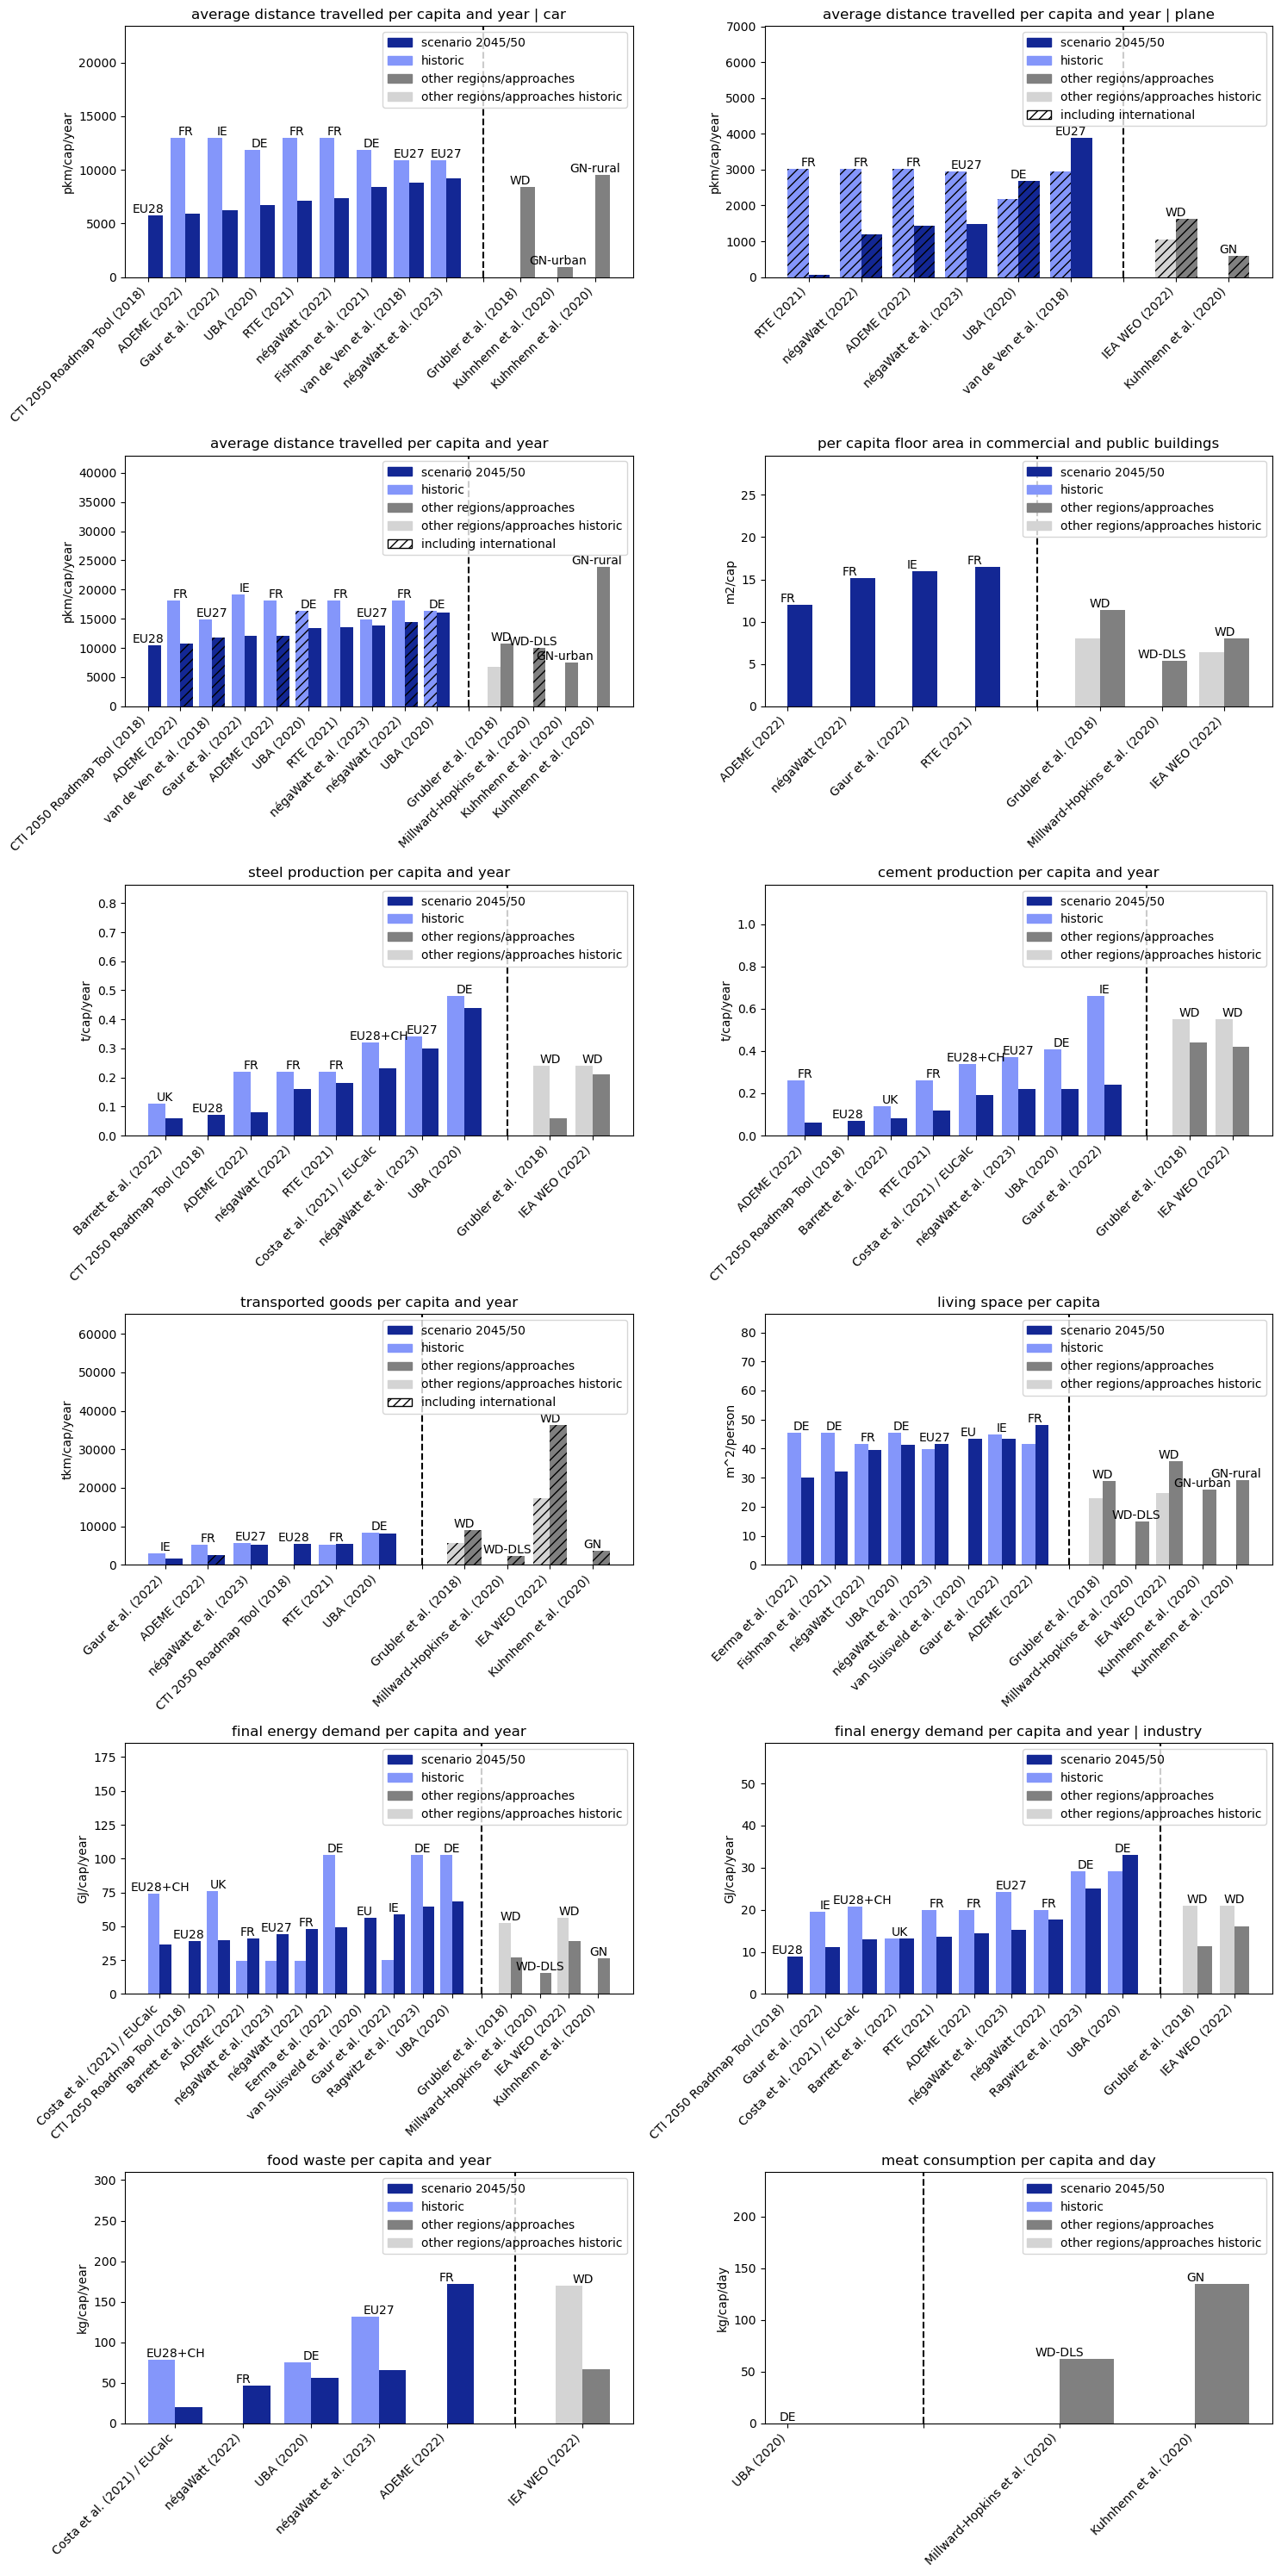

In [40]:
# Funktion to create a barplot per indicator showing tha values of all scenarios plus historic values
def make_barplot_multiple(data, filename, extension = False, standard=False,
                          show_extra_bars = True, show_scope = True, 
                          plot_individual = False, show_historic = True):
    '''
    Function to make a barplot of the values of the main indicators.
    :param data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extension: Extension of file to be exported
    :param standard: Boolean if the data is already filtered after standard scenarios or if it has to be done
    :param show_extra_bars: Boolean if extra bars should be shown
    :param show_scope: Boolean if the scope should be shown
    :param plot_individual: Boolean if the plot should be saved as individual plots
    :return: None
    '''
    # Check for the boolean standard, which indicates if the given data is already 
    # filtered after standard scenarios or if it has to be done
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data
    main_indicators = get_main_indicators(analysis_standard_df)

    # Check if the plot should be saved as individual plots
    if not plot_individual:
    # Define number of columns for the subplots
        cols = 2
        rows = len(main_indicators) // cols

        # Create a figure of subplots
        fig, axs = plt.subplots(rows, cols, figsize=(15,30))

    # Iterate over the indicators and make a plot for each índicator
    for i, indicator in enumerate(main_indicators):

        # Check if the plot should be saved as individual plots. If not create a single plot
        if plot_individual:
            fig, ax = plt.subplots(1)
        else:
            # Calculate current row and column 
            row = i // cols
            col = i % cols
            ax = axs[row, col]

        # Get the data for the current indicator
        indicator_data = analysis_standard_df[analysis_standard_df['Main comparison parameter'] == indicator]\
                            .copy().reset_index()
        indicator_data = indicator_data[['Source', 
                                         'Geographic scope', 
                                         'Scenario (name/historic/DLS)', 
                                         'Sector',
                                         'Main comparison parameter',
                                         'Parameter',
                                         'Unit',
                                         'Value']]
        indicator_data['Value'] = pd.to_numeric(indicator_data['Value'], errors='coerce')
        indicator_data['Color'] = indicator_data['Geographic scope']\
                                    .apply(lambda x: scope_colors[x] if x in scope_colors.keys() else scope_colors['single'])
        indicator_data['Label'] = indicator_data['Geographic scope']\
                                    .apply(lambda x: x if x in scope_colors.keys() else 'single')
        indicator_data['Historic'] = np.nan

        # Check if the indicator is international
        if indicator in international_parameters:
            indicator_data['International'] = indicator_data['Parameter'].str.contains('international')

        else:
            indicator_data['International'] = False
        
        indicator_data = indicator_data.sort_values('Value')


        # Get the historic data for the current indicator and each scenario
        indicator_data = get_historic_values(analysis_df, indicator_data, indicator)

        # Get the x-positions for the bars
        x = np.arange(len(indicator_data))
        
        if show_historic:
            # Plot the scenario values
            bar_scenarios = ax.bar(x+0.2, 
                        indicator_data['Value'].values,
                        width = 0.4,
                        color = study_colors['scenario 2045/50'],
                        label='scenario 2045/50')
            # Plot the historic values
            bar_hist = ax.bar(x-0.2, 
                        indicator_data['Historic'].values,
                        width = 0.4,
                        color = study_colors['historic'],
                        label='historic')
            
            # Make plots containing international values hatched
            for index in indicator_data[indicator_data['International'].values].index.values:
                bar_scenarios.patches[index].set_hatch('///')

            for index in indicator_data[indicator_data['International Historic'].values].index.values:
                bar_hist.patches[index].set_hatch('///')
        else:
            # Plot the scenario values
            bar_scenarios = ax.bar(x+0.2, 
                        indicator_data['Value'].values,
                        width = 0.4,
                        color = study_colors['scenario 2045/50'],
                        label='scenario 2045/50')

            # Make plots containing international values hatched
            international_data = indicator_data[indicator_data['International'].values].index.values
            for index in international_data:
                bar_scenarios.patches[index].set_hatch('///')
            
            # Plot the historic value as a line
            line_hist = ax.axhline(y=indicator_data['Historic'].values[0], 
                                   color='black', linestyle='--', 
                                   label='historic')
        # If the Scope should be shone (Not for Germany only plots)
        if show_scope:

            # Write the scope for each scenario over the bars (Over the highest bar between historic and scenario value)
            for i, rect_scen in enumerate(bar_scenarios):
                if show_historic:
                    rect_hist = bar_hist[i]
                    height = max(rect_scen.get_height(), rect_hist.get_height())
                else:
                    height = rect_scen.get_height()
                scope_study = indicator_data.iloc[i]['Geographic scope']
                if scope_study in map_scope_reverse:
                    scope = map_scope_reverse[scope_study] 
                else:
                    scope = scope_study
                ax.text(rect_scen.get_x(), height, scope, ha='center', va='bottom')

        # Get the naming for the x-ticks
        x_ticks = list(indicator_data['Source'].values)
        
        # If the extra bars should be shown get the data for the extra bars
        if show_extra_bars:

            # Get additional data
            sources =  ['Grubler et al. (2018)', 'Millward-Hopkins et al. (2020)', 'IEA WEO (2022)', 'Kuhnhenn et al. (2020)']
            add_data = get_additional_data(data, indicator, sources)

            # Make a vertical line to seperate the extra plots
            x_ticks.append('')
            x = len(indicator_data['Source'].values)
            ax.axvline(x, color='#030303', linestyle='--')
            x += 1

            # Create new array for x positions of the extra bars
            x = np.arange(x, x + len(add_data))
            
            # Plot the scenario values
            bar_scenarios = ax.bar(x+0.2, 
                        add_data['Value'].values,
                        width = 0.4,
                        color = study_colors['other regions/approaches'],
                        label='other regions/approaches')
            
            # Plot the historic values
            bar_hist = ax.bar(x-0.2, 
                        add_data['Historic'].values,
                        width = 0.4,
                        color = study_colors['other regions/approaches historic'],
                        label='other regions/approaches historic')

            # Make plots containing international values hatched
            for index in add_data[add_data['International'].values].index.values:
                bar_scenarios.patches[index].set_hatch('///')

            for index in add_data[add_data['International Historic'].values].index.values:
                bar_hist.patches[index].set_hatch('///')
            
            # Write the scope for each scenario over the bars (Over the highest bar between historic and scenario value)
            for i, rect_scen in enumerate(bar_scenarios):
                rect_hist = bar_hist[i]
                height = max(rect_scen.get_height(), rect_hist.get_height())
                scope_study = add_data.iloc[i]['Geographic scope']
                if scope_study in map_scope_reverse:
                    scope = map_scope_reverse[scope_study] 
                else:
                    scope = scope_study
                ax.text(rect_scen.get_x(), height, scope, ha='center', va='bottom')
            
            # Add the sources to the x_ticks for labeling the x axis
            x_ticks += add_data['Source'].values.tolist()

            # manually define a new patch 
            patches = [mpatches.Patch(color=study_colors[x], label=x) for x in study_colors.keys()]

            # When the indicator is international add a patch for international (with hatch)
            if indicator in international_parameters:
                patches.append(mpatches.Patch(color='black', fill=False, hatch='///', label='including international'))
            # plot the legend
            ax.legend(handles=patches, loc='upper right')
            
        
        else:
            # Get the correct legend without duplicate keys
            handles, labels = ax.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax.legend(by_label.values(), by_label.keys(), title='Scope', loc='upper right')

        # Configure plot
        ax.set_title(f'{indicator}')
        ax.set_ylabel(indicator_data['Unit'].values[0])
        ax.set_xticks(np.arange(len(x_ticks)),x_ticks, rotation=45, ha="right")

        # Get the maximum Value of the bar plot to set the limit a bit higher than the max value
        max_value = max([x.get_height() for x in ax.patches])
        ax.set_ylim(0, max_value* 1.8)
        
        if plot_individual:
            # Save figure either with default extension or with extension given in the function
            if extension:
                filename = f'{filename}.{extension}'
            # Save the figure as png
            indicator_naming = indicator.replace('|', '')
            plt.savefig(f'figures/{filename}_{indicator_naming}', bbox_inches = "tight")


    # Make a nicer look
    plt.tight_layout()
    # Save figure either with default extension or with extension given in the function
    if extension:
        filename = f'{filename}.{extension}'
    # Save the figure as png
    plt.savefig(f'figures/{filename}', bbox_inches = "tight")


# Call function for making barplots
make_barplot_multiple(analysis_df, 'barplot_values', plot_individual=False)

##### 3.1.3 Boxplot of Values

To show the variance in the indicators, make a boxplot for each indicator, where the relative change to the median is shown.

In [41]:
# Creates a result corresponding to the plot containing all Datapoints
def create_result_table_boxplot(indicator_table_data, filename, extra_columns=[], ):
    '''
    Function to create a result table corresponding to the plot containing all Datapoints
    :param indicator_table_data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extra_columns: List of extra columns to be added to the result table
    :return: None
    '''
    wanted_columns = ['Source', 'Geographic scope', 'Scenario (name/historic/DLS)', 'Sector', 'Main comparison parameter', 'Year', 'Unit', 'Value'] + extra_columns
    table_data = indicator_table_data[wanted_columns].copy()
    table_data['Zeile im Spreadsheet'] = table_data.index + 1
    table_data.to_excel(f'output/{filename}.xlsx', index=False)



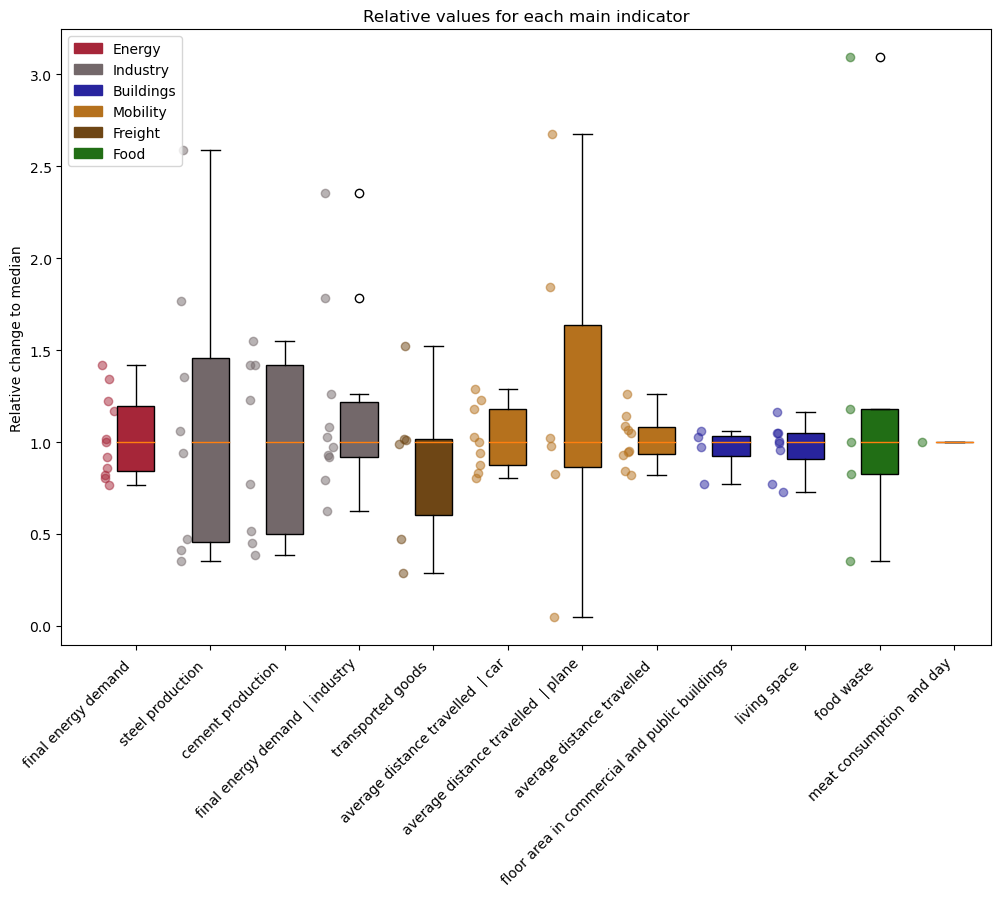

In [42]:
# Function makes a boxplot where for each indicator the realitve change to the median is shown
def make_boxplot(data, filename, extension = False, standard=False):
    '''
    Function to make a boxplot of the relative change to the median of the main indicators.
    :param data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extension: Extension of file to be exported
    :param standard: Boolean if the data is already filtered after standard scenarios or if it has to be done
    :return: None
    '''
    # Check for the boolean standard, which indicates if the given data is already filtered after standard scenarios or if it has to be done
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data

    # Get the main indicators
    main_indicators = get_main_indicators(analysis_standard_df)
    
    # Create Dataframe for the plotting
    main_indicators_plotting_df = pd.DataFrame(columns=['Indicator', 'Sector', 'Color', 'Order'])
    main_indicators_plotting_df['Indicator'] = main_indicators
    main_indicators_plotting_df['Sector'] =  main_indicators_plotting_df['Indicator'].apply(lambda x: sectors_df[sectors_df['Parameter']==x]['Sector'].values[0])
    main_indicators_plotting_df['Color'] = main_indicators_plotting_df['Sector'].apply(lambda x: sector_colours[x])
    main_indicators_plotting_df['Order'] =  main_indicators_plotting_df['Sector'].apply(lambda x: sector_order[x])
    main_indicators_plotting_df = main_indicators_plotting_df.sort_values(by=['Order'], ascending=[True])
    main_indicators = main_indicators_plotting_df['Indicator'].values

    # Make a boxplot per Indicator
    # Calculate the Median for each Indicator and then the Percentage difference
    boxplot_data = {}
    indicator_table_data = pd.DataFrame()    

    # Iterate over the indicators and calculate the median and the difference to it
    for i, indicator in enumerate(main_indicators):

        # get the data for the current indicator
        indicator_data = analysis_standard_df[analysis_standard_df['Main comparison parameter'] == indicator].copy()
        
        # Filter out the kcal per capita and year
        #indicator_data = indicator_data[~indicator_data['Unit'].str.contains('kcal')]        
        indicator_values = indicator_data['Value']

        # Get the median
        indicator_median = indicator_values.median()
        
        # Add new columns for Median and Relative Change
        indicator_data['Median'] = indicator_median
        indicator_data['Relative Change'] = indicator_data['Value'] / indicator_median
        indicator_table_data = pd.concat([indicator_table_data, indicator_data])
        
        # Calculate the relative change to the median
        indicator_relative = indicator_values / indicator_median
        boxplot_data[indicator] = indicator_relative

    # Make a result Table for the Plot
    create_result_table_boxplot(indicator_table_data,  f'{filename}_table', ['Median', 'Relative Change'])

    # Make a boxplot for the indicator values
    fig, ax = plt.subplots(1, figsize=(12, 8))
    bplot = ax.boxplot(boxplot_data.values(), 
                    showfliers=True, 
                    patch_artist=True)

    # Add the datapoints as scatter
    for i, key in enumerate(boxplot_data.keys()):
        y = boxplot_data[key]
        x = np.random.normal(i+0.6, 0.04, size=len(y))
        color = main_indicators_plotting_df[main_indicators_plotting_df['Indicator'] == key]['Color'].values[0]
        ax.scatter(x, y, c=color, alpha=0.5)

    # Fill with colors according to the sector
    colors = [main_indicators_plotting_df[main_indicators_plotting_df['Indicator'] == key]['Color'].values[0] for key in boxplot_data.keys()]
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    # Configure the plot
    ax.set_title(f'Relative values for each main indicator')
    ax.set_ylabel('Relative change to median')
    naming_x_axis = [s.replace('per capita and year', '').replace('per capita', '') for s in boxplot_data.keys()] 
    ax.set_xticks(np.arange(start=1, stop=len(naming_x_axis)+1), naming_x_axis, rotation=45, ha="right")
    ax.set_xlim(0)

    # manually define a new patch for the legend
    patches = [mpatches.Patch(color=sector_colours[x], label=x) for x in sector_colours.keys()]

    # plot the legend
    ax.legend(handles=patches, loc='upper left')
    
    # Save figure either with default extension or with extension given in the function
    if extension:
        filename = f'{filename}.{extension}'
    # Save the plot as png
    plt.savefig(f'figures/{filename}', bbox_inches = "tight")

make_boxplot(analysis_df, 'boxplot_values')

##### 3.1.4 Make Boxplot of DLS

For each indicator where there is a DLS value, show the difference to this Value as a Boxplot

In [43]:
# Function gets the dls-values for and indicator for 
def get_dls(indicator, data):
    '''
    Function to get the DLS values for an indicator.
    :param indicator: Indicator to filter after
    :param data: Data from the Scenario Analysis sheet
    :return: Dataframe with only the DLS values
    '''
    # Get Data for the Hilward Hopkins et al. (2020) study
    data_hilward_hopkins = data[(data['Source'] == 'Millward-Hopkins et al. (2020)') & (data['Main comparison parameter'] == indicator)].copy()
    if len(data_hilward_hopkins) != 0:
        value_hilward_hopkins = float(data_hilward_hopkins['Value'].values[0])
    else:
        value_hilward_hopkins = np.nan
    return value_hilward_hopkins       

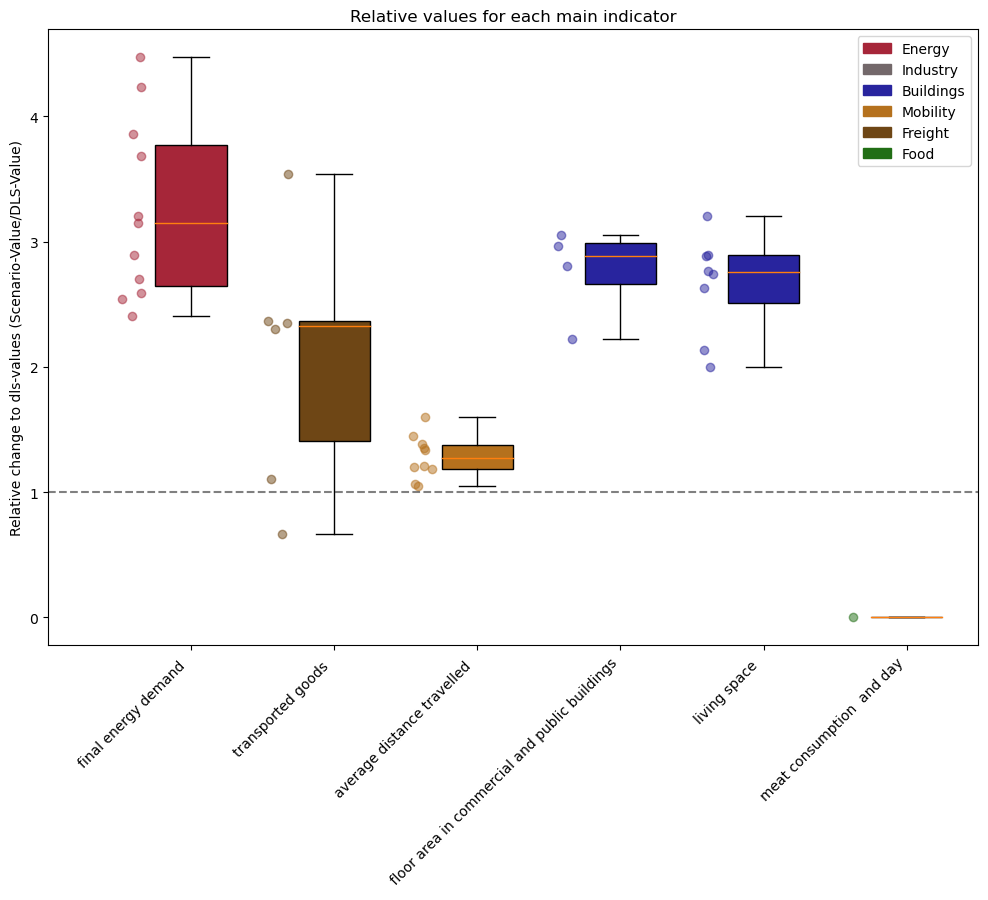

In [44]:
# Makes a boxplot showing the relative difference of scenario values to the dls values
def make_boxplot_dls(data, filename, extension = False, standard=False, raw_data=False):
    '''
    Function to make a boxplot of the relative change to the dls values of the main indicators.
    :param data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extension: Extension of file to be exported
    :param standard: Boolean if the data is already filtered after standard scenarios or if it has to be done
    :param raw_data: Boolean if the raw data should be used instead of the filtered data
    :return: None
    '''
    # Check for the boolean standard, which indicates if the given data is already filtered after standard scenarios or if it has to be done
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data
        data = raw_data

    # Get the main indicators
    main_indicators = get_main_indicators(analysis_standard_df)

    # Create Dataframe for the plotting
    main_indicators_plotting_df = pd.DataFrame(columns=['Indicator', 'Sector', 'Color', 'Order', 'DLS'])
    main_indicators_plotting_df['Indicator'] = main_indicators
    main_indicators_plotting_df['Sector'] =  main_indicators_plotting_df['Indicator'].apply(lambda x: sectors_df[sectors_df['Parameter']==x]['Sector'].values[0])
    main_indicators_plotting_df['Color'] = main_indicators_plotting_df['Sector'].apply(lambda x: sector_colours[x])
    main_indicators_plotting_df['Order'] =  main_indicators_plotting_df['Sector'].apply(lambda x: sector_order[x])
    main_indicators_plotting_df['DLS'] =  main_indicators_plotting_df['Indicator'].apply(lambda x: get_dls(x, data))
    main_indicators_plotting_df = main_indicators_plotting_df.sort_values(by=['Order'])
    main_indicators_plotting_df = main_indicators_plotting_df.set_index('Indicator')
    main_indicators = main_indicators_plotting_df.index

    # Make a boxplot per Indicator
    # Calculate the Median for each Indicator and then the Percentage difference
    boxplot_data = {}
    indicator_table_data = pd.DataFrame()

    # Iterate over the indicators and calculate the median and the difference to it
    for i, indicator in enumerate(main_indicators):

        # get the data for the current indicator
        indicator_data = analysis_standard_df[analysis_standard_df['Main comparison parameter'] == indicator].copy()
        indicator_values = indicator_data['Value']

        # Get the median
        indicator_dls = main_indicators_plotting_df.at[indicator, 'DLS']

        if pd.isnull(indicator_dls):
            continue

        # Calculate the relative change to the median
        indicator_relative = indicator_values / indicator_dls

        # Add new columns for Median and Relative Change
        indicator_data['DLS'] = indicator_dls
        indicator_data['Relative Change'] = indicator_data['Value'] / indicator_dls
        indicator_table_data = pd.concat([indicator_table_data, indicator_data])

        boxplot_data[indicator] = indicator_relative

    # Creates a results table as excel containing all the datapoints
    create_result_table_boxplot(indicator_table_data,  f'{filename}_table', ['DLS', 'Relative Change'])

    # Make a boxplot for the indicator values
    fig, ax = plt.subplots(1, figsize=(12, 8))
    bplot = ax.boxplot(boxplot_data.values(), 
                    showfliers=True, 
                    patch_artist=True)

    # Add the datapoints as scatter
    for i, key in enumerate(boxplot_data.keys()):
        y = boxplot_data[key]
        x = np.random.normal(i+0.6, 0.04, size=len(y))
        color = main_indicators_plotting_df.at[key, 'Color']
        ax.scatter(x, y, c=color, alpha=0.5)

    # fill with colors
    colors = [main_indicators_plotting_df.at[key, 'Color'] for key in boxplot_data.keys()]
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    ax.set_title(f'Relative values for each main indicator')
    ax.set_ylabel('Relative change to dls-values (Scenario-Value/DLS-Value)')
    naming_x_axis = [s.replace('per capita and year', '').replace('per capita', '') for s in boxplot_data.keys()] 
    ax.set_xticks(np.arange(start=1, stop=len(naming_x_axis)+1), naming_x_axis, rotation=45, ha="right")
    ax.set_xlim(0)
    # Make a horizontal loine to show the 1 line (When value is 1, no change happened)
    ax.axhline(1, color='#030303', linestyle='--', alpha=0.5)

    # manually define a new patch 
    patches = [mpatches.Patch(color=sector_colours[x], label=x) for x in sector_colours.keys()]

    # plot the legend
    ax.legend(handles=patches, loc='upper right')

    # Save figure either with default extension or with extension given in the function
    if extension:
        filename = f'{filename}.{extension}'
    plt.savefig(f'figures/{filename}', bbox_inches = "tight")

make_boxplot_dls(analysis_df, 'boxplot_dls')

##### 3.1.5 Make Boxplot Historic

For each indicator show the differences to the historic values.

In [45]:
# Get the historic data for one main indicator and study
def get_historic(row, data):
    '''
    Function to get the historic data for one main indicator and study.
    :param row: Row of the data
    :param data: Data from the Scenario Analysis sheet
    :return: Historic value
    '''
    # Get the historic data for the indicator
    historic_data = get_historic_data(data, row['Main comparison parameter'])

    # Get the source and scope of the study
    scenario = row['Source']
    scope = row['Geographic scope']

    # Check if a historic value for négaWatt is available
    if len(historic_data[(historic_data['Source'] == 'négaWatt et al. (2023)') & (historic_data['Geographic scope'] == scope)]):
        historic_value = historic_data[(historic_data['Source'] == 'négaWatt et al. (2023)') & (historic_data['Geographic scope'] == scope)]['Value'].values[0]

    # Else check if a historic value of the scenario is available
    elif len(historic_data[(historic_data['Source'] == scenario) & (historic_data['Geographic scope'] == scope)]):
        historic_value = historic_data[(historic_data['Source'] == scenario) & (historic_data['Geographic scope'] == scope)]['Value'].values[0]
    
    # Otherwise check if a historic value of the scope is available
    elif scope in historic_data['Geographic scope'].values:
        historic_value = historic_data[historic_data['Geographic scope'] == scope]['Value'].values[0]

    # Otherwise no historic value is available
    else:
        historic_value = np.nan

    return historic_value

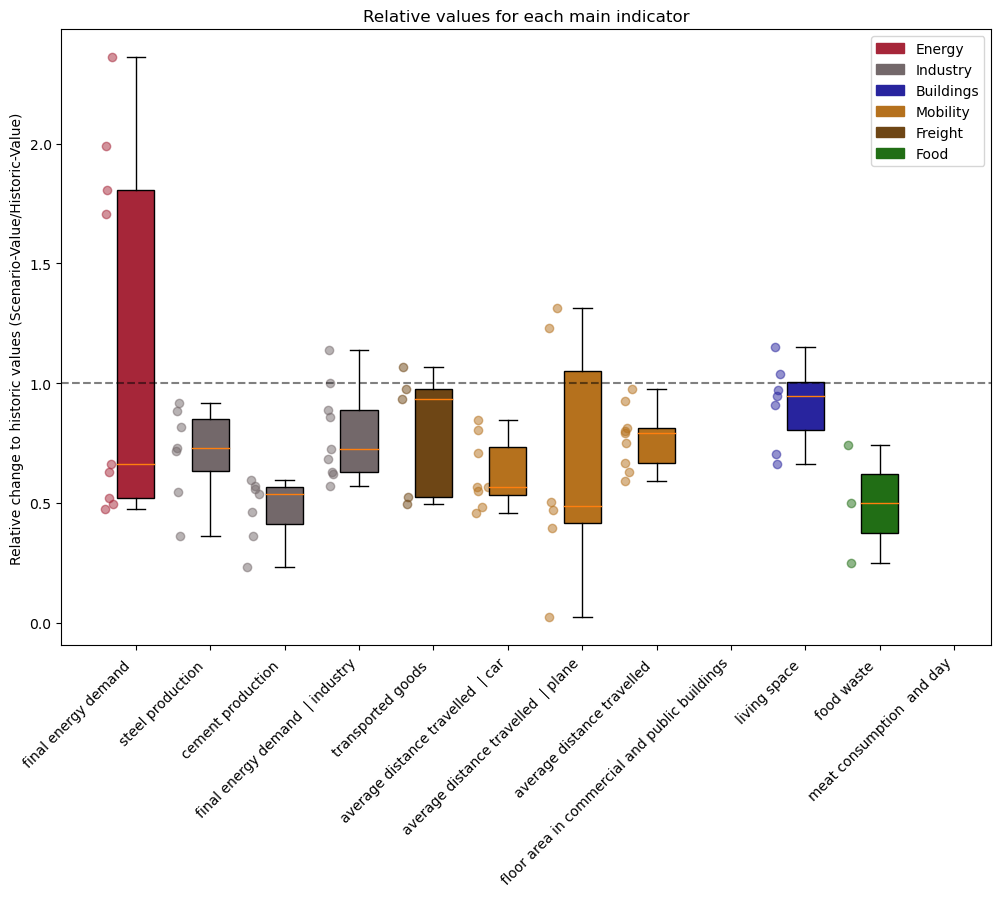

In [46]:
# Makes a boxplot showing the relative difference between each scenario and the corresponding historic value
def make_boxplot_historic(data, filename, extension = False, standard=False, raw_data=False):
    '''
    Function to make a boxplot of the relative change to the historic values of the main indicators.
    :param data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extension: Extension of file to be exported
    :param standard: Boolean if the data is already filtered after standard scenarios or if it has to be done
    :param raw_data: Boolean if the raw data should be used instead of the filtered data
    :return: None
    '''
    # Check for the boolean standard, which indicates if the given data is already filtered after standard scenarios or if it has to be done
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data
        data = raw_data

    # Get the main indicators
    main_indicators = get_main_indicators(analysis_standard_df)

    # Create Dataframe for the plotting
    main_indicators_plotting_df = pd.DataFrame(columns=['Indicator', 'Sector', 'Color', 'Order'])
    main_indicators_plotting_df['Indicator'] = main_indicators
    main_indicators_plotting_df['Sector'] =  main_indicators_plotting_df['Indicator'].apply(lambda x: sectors_df[sectors_df['Parameter']==x]['Sector'].values[0])
    main_indicators_plotting_df['Color'] = main_indicators_plotting_df['Sector'].apply(lambda x: sector_colours[x])
    main_indicators_plotting_df['Order'] =  main_indicators_plotting_df['Sector'].apply(lambda x: sector_order[x])
    main_indicators_plotting_df = main_indicators_plotting_df.sort_values(by=['Order'])
    main_indicators_plotting_df = main_indicators_plotting_df.set_index('Indicator')
    main_indicators = main_indicators_plotting_df.index

    # Make a boxplot per Indicator
    # Calculate the Median for each Indicator and then the Percentage difference
    boxplot_data = {}
    indicator_table_data = pd.DataFrame()

    # Iterate over the indicators and calculate the median and the difference to it
    for i, indicator in enumerate(main_indicators):

        # get the data for the current indicator
        indicator_data = analysis_standard_df[analysis_standard_df['Main comparison parameter'] == indicator].copy()
        indicator_data['Historic'] =  indicator_data.apply(lambda x: get_historic(x, data), axis=1)
        indicator_data = indicator_data.dropna(subset=['Historic'])
        indicator_data['Value'] = pd.to_numeric(indicator_data['Value'], errors='coerce')
        indicator_data['Historic'] = pd.to_numeric(indicator_data['Historic'], errors='coerce')    
        indicator_values = indicator_data['Value']

        # Get the histroic Values
        indicator_historic = indicator_data['Historic']

        # Calculate the relative change to the historic value
        indicator_relative = indicator_values / indicator_historic
        boxplot_data[indicator] = indicator_relative

        indicator_data['Relative Change'] = indicator_data['Value'] / indicator_historic
        indicator_table_data = pd.concat([indicator_table_data, indicator_data])

    create_result_table_boxplot(indicator_table_data, f'{filename}_table', ['Historic', 'Relative Change'])

    # Make a boxplot for the indicator values
    fig, ax = plt.subplots(1, figsize=(12, 8))
    bplot = ax.boxplot(boxplot_data.values(), 
                    showfliers=True, 
                    patch_artist=True)

    # Add the datapoints as scatter
    for i, key in enumerate(boxplot_data.keys()):
        y = boxplot_data[key]
        x = np.random.normal(i+0.6, 0.04, size=len(y))
        color = main_indicators_plotting_df.at[key, 'Color']
        ax.scatter(x, y, c=color, alpha=0.5)

    # fill with colors
    colors = [main_indicators_plotting_df.at[key, 'Color'] for key in boxplot_data.keys()]
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    ax.set_title(f'Relative values for each main indicator')
    ax.set_ylabel('Relative change to historic values (Scenario-Value/Historic-Value)')
    naming_x_axis = [s.replace('per capita and year', '').replace('per capita', '') for s in boxplot_data.keys()] 
    ax.set_xticks(np.arange(start=1, stop=len(naming_x_axis)+1), naming_x_axis, rotation=45, ha="right")
    ax.set_xlim(0)

    # Make a horizontal loine to show the 1 line (When value is 1, no change happened)
    ax.axhline(1, color='#030303', linestyle='--', alpha=0.5)

    # manually define a new patch 
    patches = [mpatches.Patch(color=sector_colours[x], label=x) for x in sector_colours.keys()]

    # plot the legend
    ax.legend(handles=patches, loc='upper right')

    # Save figure either with default extension or with extension given in the function
    if extension:
        filename = f'{filename}.{extension}'
    plt.savefig(f'figures/{filename}', bbox_inches = "tight")

make_boxplot_historic(analysis_df, 'boxplot_historic')

##### 3.1.5´6 Make a scatter plot

This plot shows for each indicator a scatter plot, where the scenario valus is shown over the historic value.

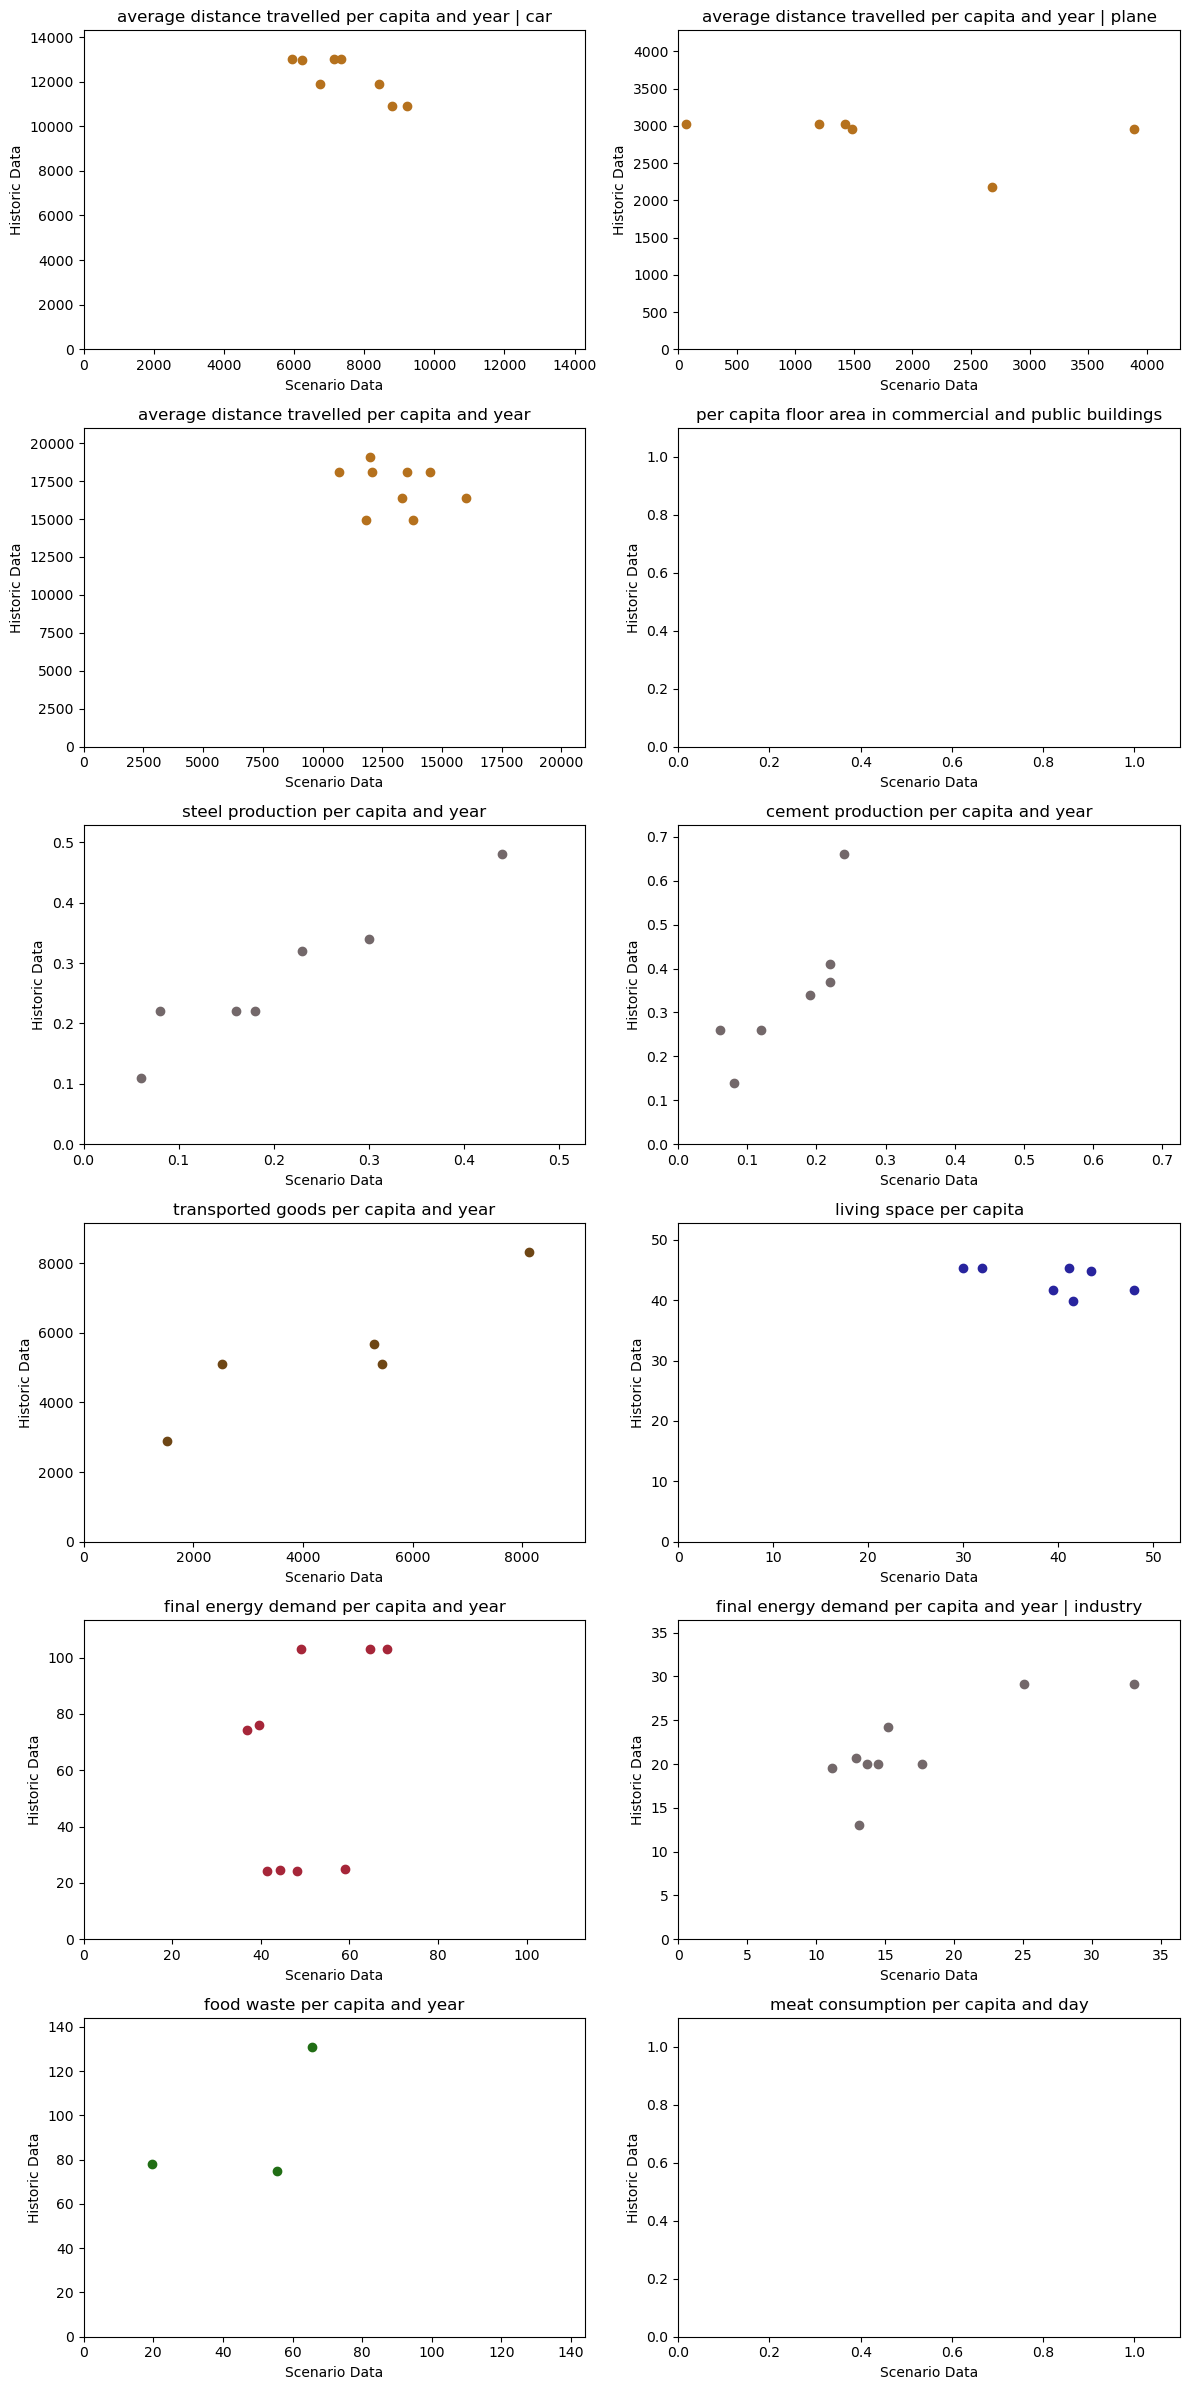

In [47]:
# Makes a scatter plot per indicator showing the scenario value over the historic value
def make_scatter_plot(data, filename, extension = False, standard=False):
    '''
    Function to make a scatter plot of the scenario values over the historic values of the main indicators.
    :param data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extension: Extension of file to be exported
    :param standard: Boolean if the data is already filtered after standard scenarios or if it has to be done
    :return: None
    '''
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data

    main_indicators = get_main_indicators(analysis_standard_df)

    historic_data = get_historic_data(data)

    # Create Dataframe for the plotting
    main_indicators_plotting_df = pd.DataFrame(columns=['Indicator', 'Sector', 'Color', 'Order', 'DLS'])
    main_indicators_plotting_df['Indicator'] = main_indicators
    main_indicators_plotting_df['Sector'] =  main_indicators_plotting_df['Indicator'].apply(lambda x: sectors_df[sectors_df['Parameter']==x]['Sector'].values[0])
    main_indicators_plotting_df['Color'] = main_indicators_plotting_df['Sector'].apply(lambda x: sector_colours[x])
    main_indicators_plotting_df = main_indicators_plotting_df.set_index('Indicator')
    # Define number of columns for the subplots
    cols = 2
    rows = len(main_indicators) // cols

    # Create a figure of subplots
    fig, axs = plt.subplots(rows, cols, figsize=(12,24))

    # Iterate over the indicators and make a plot for each índicator
    for i, indicator in enumerate(main_indicators):
        
        # Calculate current row and column 
        row = i // cols
        col = i % cols
        ax = axs[row, col]

        # Get indicator data
        indicator_data = analysis_standard_df[analysis_standard_df['Main comparison parameter'] == indicator].copy()
        indicator_data['Value'] = pd.to_numeric(indicator_data['Value'], errors='coerce')
        indicator_data['Color'] = indicator_data['Geographic scope'].apply(lambda x: scope_colors[x] if x in scope_colors.keys() else scope_colors['single'])
        indicator_data['Label'] = indicator_data['Geographic scope'].apply(lambda x: x if x in scope_colors.keys() else 'single')
        indicator_data = indicator_data.sort_values('Value')

        # Get the sector of the indicator
        sector = main_indicators_plotting_df.at[indicator, 'Sector']

        # Get the historic data
        historic_data = get_historic_data(analysis_df, indicator)
        historic_plots = []
        drop_indices = []
        # Get for each scenario the corresponding historic value
        for index, row in indicator_data.iterrows():
            scenario = row['Source']
            scope = row['Geographic scope']
            # Check if a historic value for négaWatt is available
            if len(historic_data[(historic_data['Source'] == 'négaWatt et al. (2023)') & (historic_data['Geographic scope'] == scope)]):
                historic_value = historic_data[(historic_data['Source'] == 'négaWatt et al. (2023)') & (historic_data['Geographic scope'] == scope)]['Value'].values[0]
                historic_plots.append(historic_value)

            # Else check if a historic value of the scenario is available
            elif len(historic_data[(historic_data['Source'] == scenario) & (historic_data['Geographic scope'] == scope)]):
                historic_value = historic_data[(historic_data['Source'] == scenario) & (historic_data['Geographic scope'] == scope)]['Value'].values[0]
                historic_plots.append(historic_value)     

            # Otherwise check if a historic value of the scope is available
            elif scope in historic_data['Geographic scope'].values:
                historic_value = historic_data[historic_data['Geographic scope'] == scope]['Value'].values[0]
                historic_plots.append(historic_value)
            
            # Otherwise no historic value is available
            else:
                drop_indices.append(index)
            
        # Drop rows where no historic value exists
        indicator_data = indicator_data.drop(index=drop_indices)

        # Get values for plotting
        scenario_values = indicator_data['Value'].values
        historic_values = pd.to_numeric(historic_plots)
        if len(scenario_values) != 0:
            max_value = max(max(scenario_values), max(historic_values))
        else:
            max_value = 1
        ax.scatter(scenario_values, historic_values, color=sector_colours[sector])
        ax.set_title(indicator)
        ax.set_xlabel('Scenario Data')
        ax.set_ylabel('Historic Data')
        ax.set_ylim(0, max_value*1.1)
        ax.set_xlim(0, max_value*1.1)
    plt.tight_layout()
    # Save figure either with default extension or with extension given in the function
    if extension:
        filename = f'{filename}.{extension}'
    plt.savefig(f'figures/{filename}', bbox_inches = 'tight')

make_scatter_plot(analysis_df, 'scatterplot')      

#### 3.2 Germany specific plots

Make all the plots from before for the studies where the scope is only Germany.

##### 3.2.1 Get German data
First we select the data where the scope is germany. Then we use the functions from before to create plots for Germany.

In [48]:
# Filter for standard scenarios
standard_scenarios = scenarios_df[scenarios_df['germany'] == 1]
standard_scenarios_data = standard_scenarios.apply(lambda x: analysis_df[(analysis_df['Source'] == x['Source']) \
                                                                        & (analysis_df['Scenario (name/historic/DLS)'] == x['scenarios']) \
                                                                        & (analysis_df['Geographic scope'] == 'DE')].index.values, axis=1).explode()
scenario_analysis_germany_df = analysis_df.loc[standard_scenarios_data]
scenario_analysis_germany_df['Geographic scope'] = scenario_analysis_germany_df['Geographic scope'].str.replace(' ', '')
scenario_analysis_germany_df = scenario_analysis_germany_df[scenario_analysis_germany_df['Coding'] == 1]

# Remove kcal Data
scenario_analysis_germany_df = scenario_analysis_germany_df[~scenario_analysis_germany_df['Unit'].str.contains('kcal')]

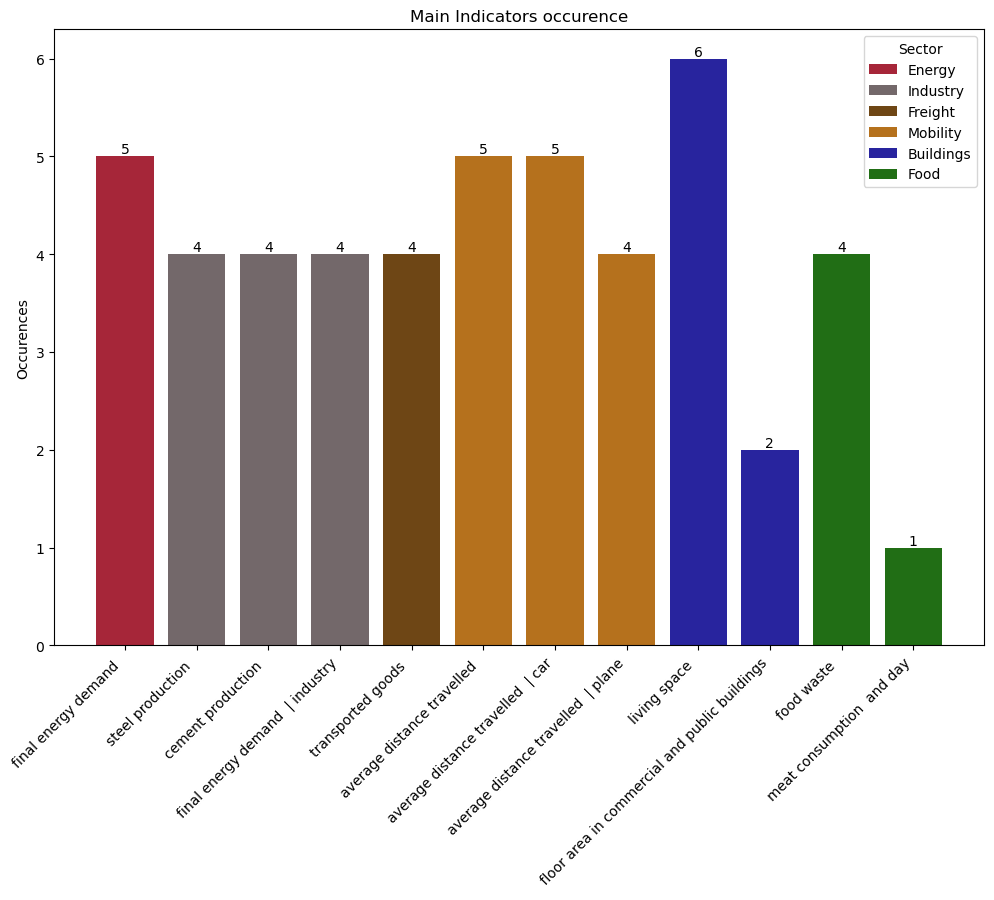

In [49]:
make_barplot_occurences(scenario_analysis_germany_df, 'barplot_occurences_germany', standard=True)

C:\Users\yanni\AppData\Local\Temp\ipykernel_36696\4254524310.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  indicator_data.at[index, 'International Historic'] = False
C:\Users\yanni\AppData\Local\Temp\ipykernel_36696\4254524310.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  indicator_data.at[index, 'International Historic'] = international
C:\Users\yanni\AppData\Local\Temp\ipykernel_36696\4254524310.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  indicator_data.at[index

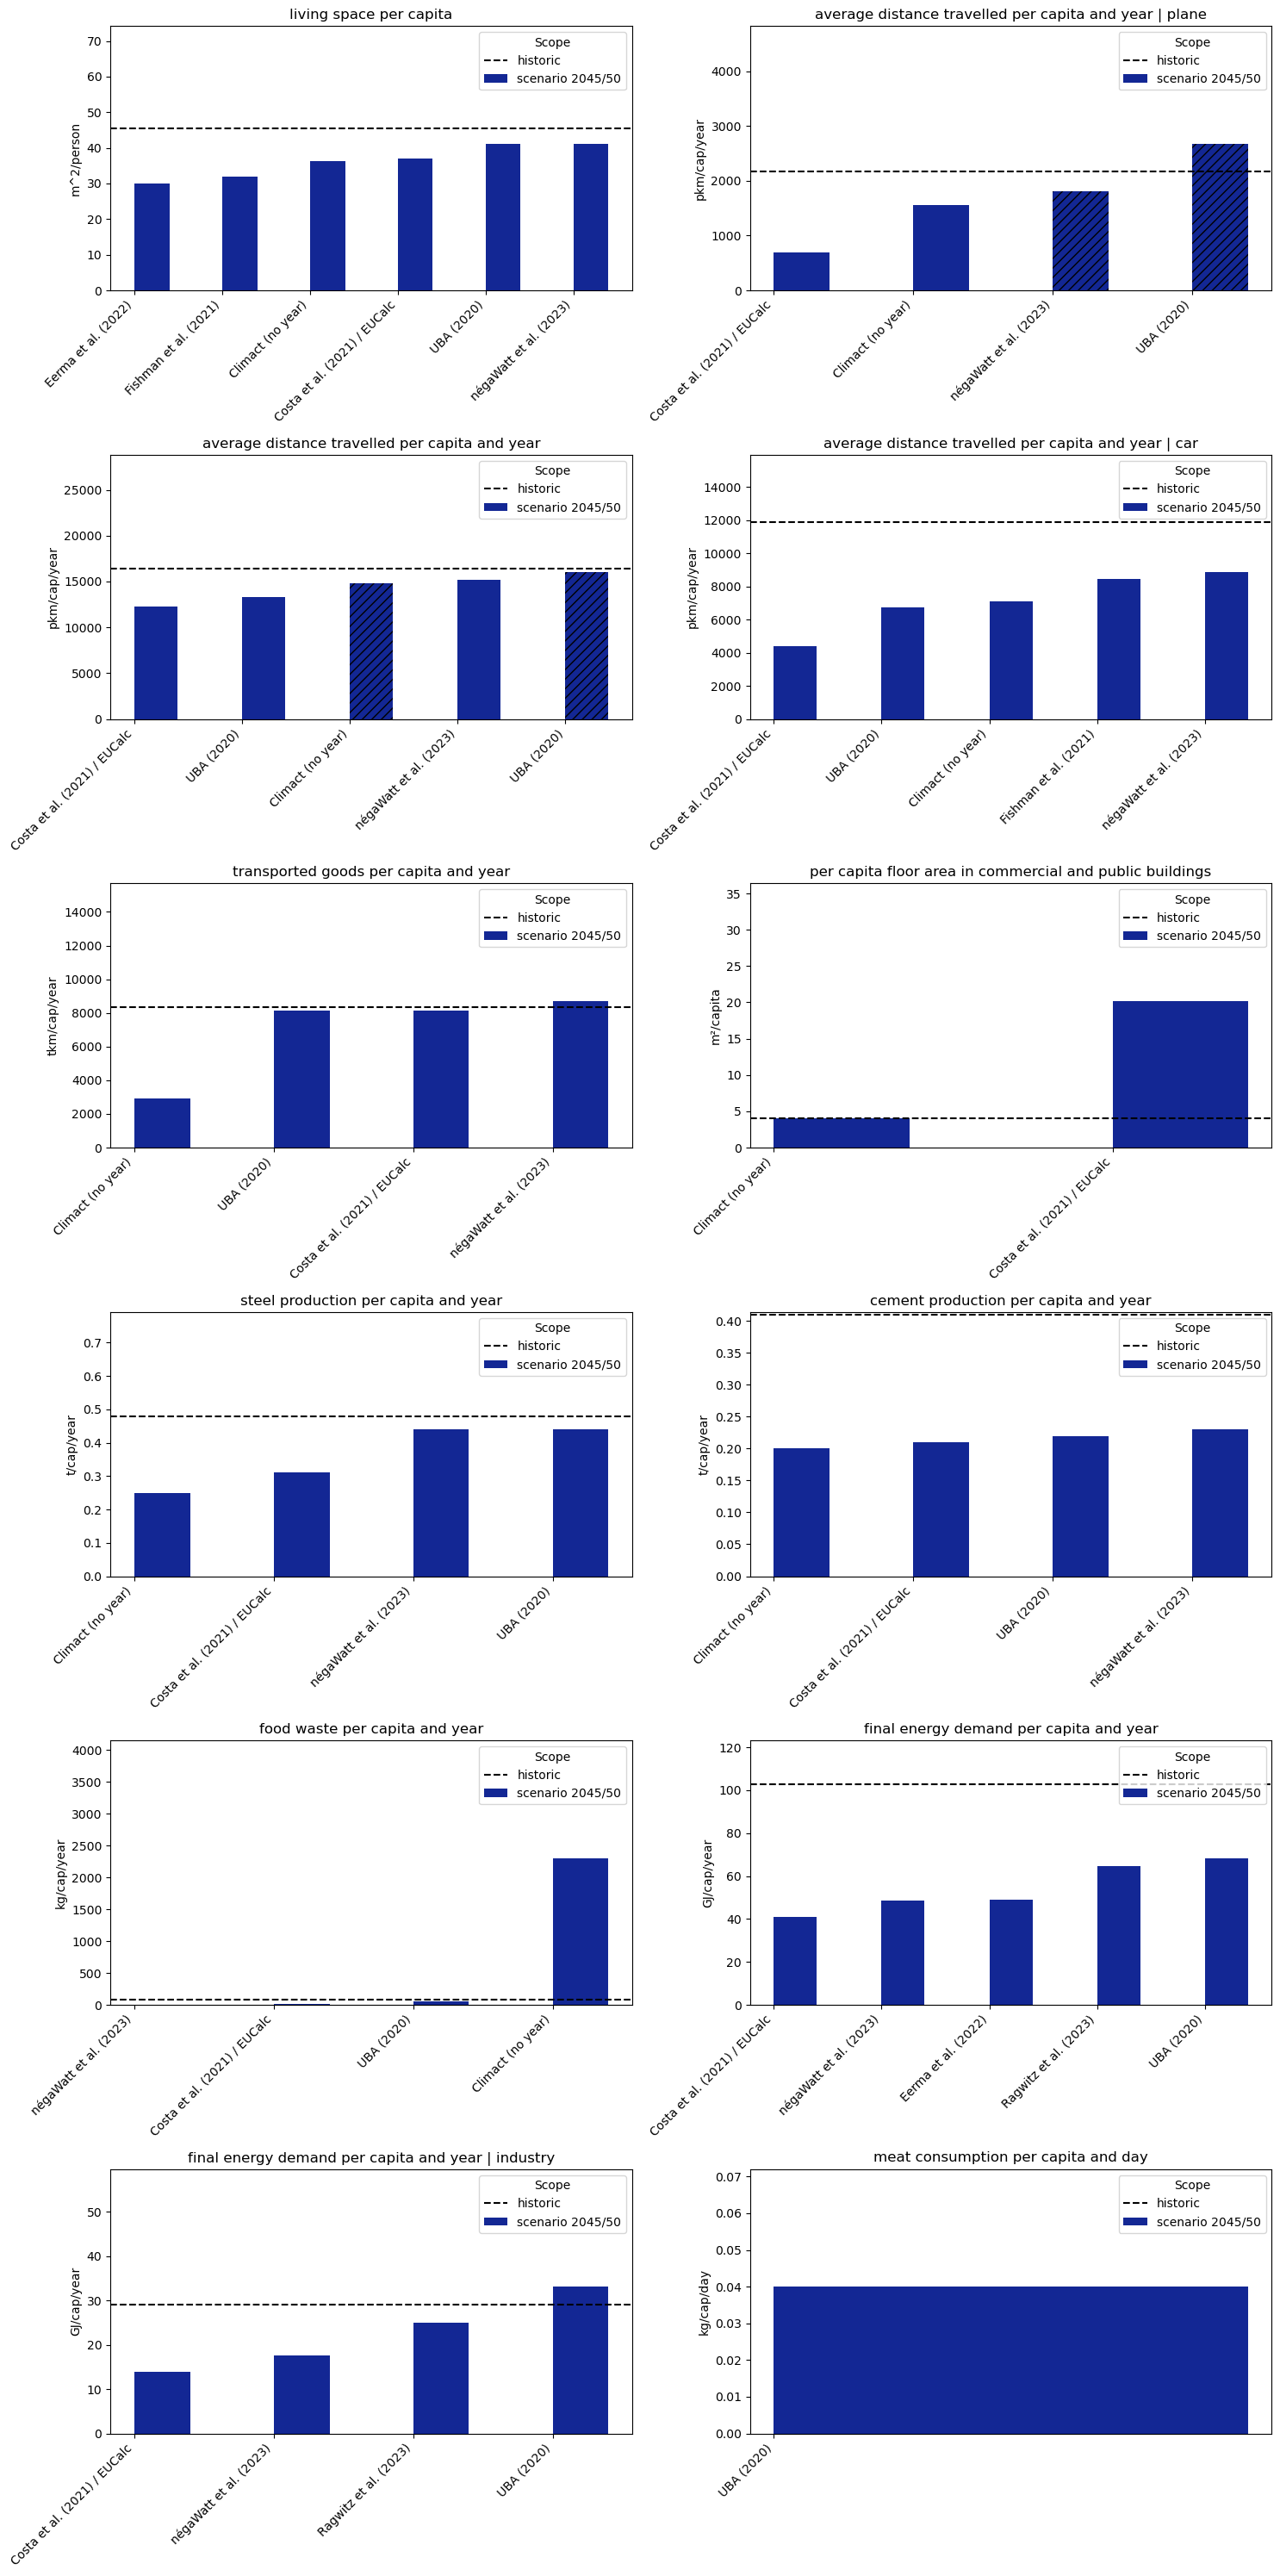

In [50]:
make_barplot_multiple(scenario_analysis_germany_df, 'barplot_values_germany', 
                      standard=True, show_extra_bars=False, show_scope = False, show_historic=False)

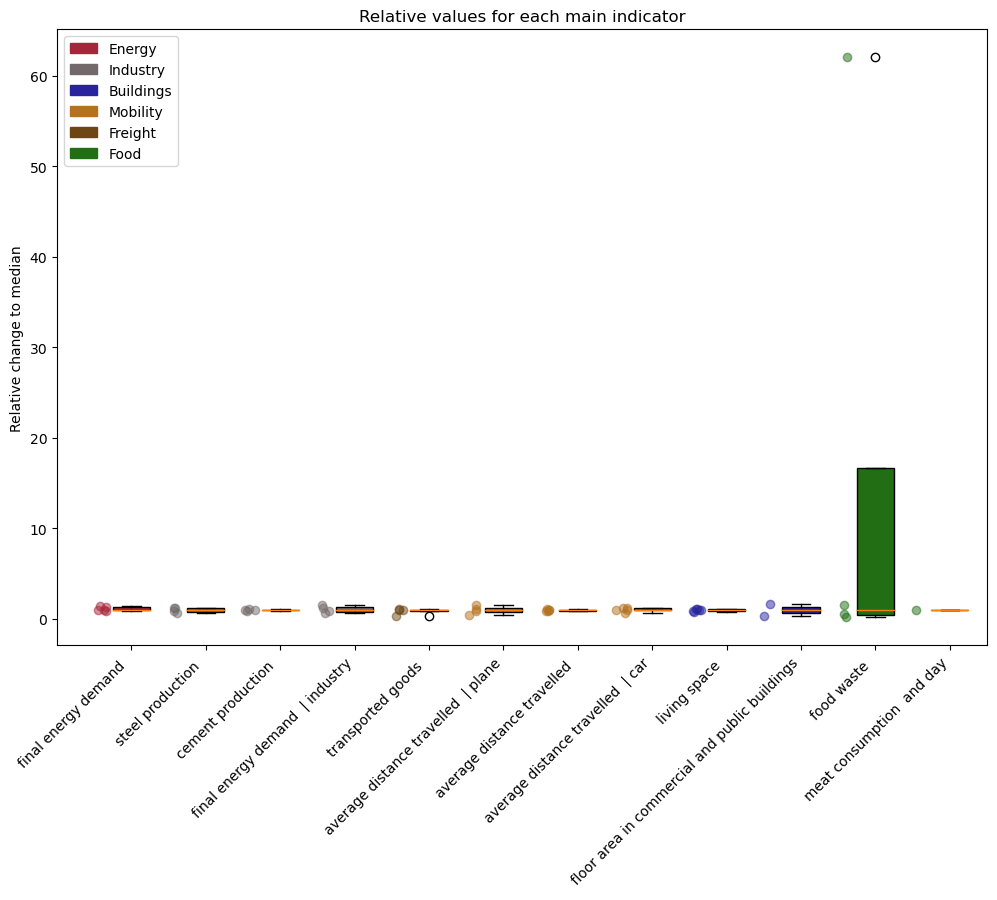

In [51]:
make_boxplot(scenario_analysis_germany_df, 'boxplot_germany', standard=True)

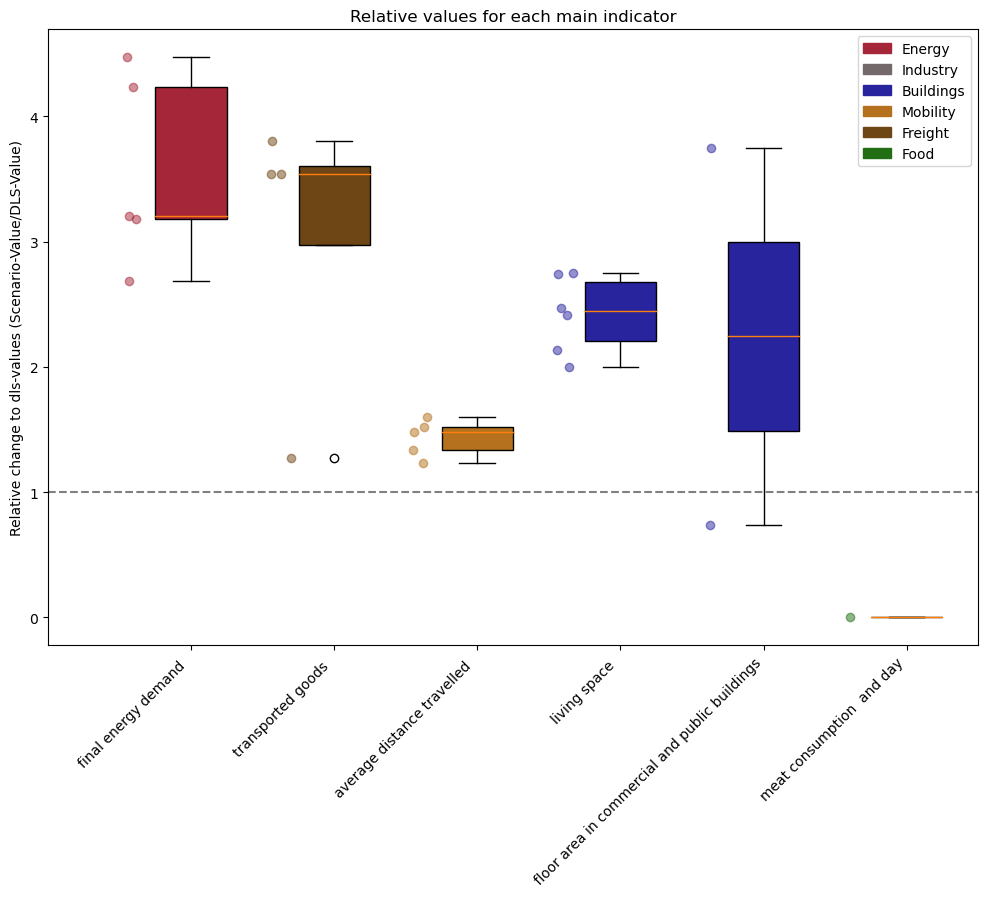

In [52]:
make_boxplot_dls(scenario_analysis_germany_df, 'boxplot_germany_dls', standard=True, raw_data=analysis_df)

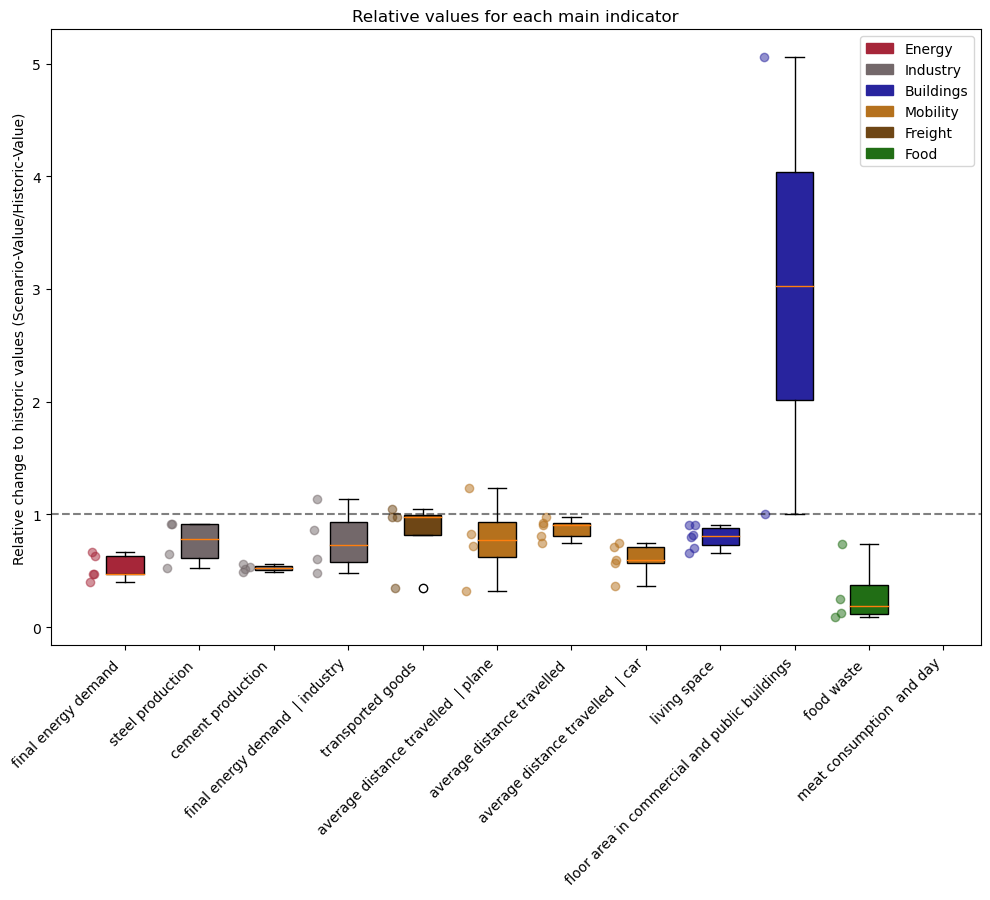

In [53]:
make_boxplot_historic(scenario_analysis_germany_df, 'boxplot_germany_historic', standard=True, raw_data=analysis_df)